In [1]:
from All_functions_simulation_univariate import * 
from All_Functions_FF import my_plot 
from sklearn.linear_model import QuantileRegressor

In [2]:
##################### Data preparation ###################

data = pd.read_csv('FFData.CSV')

MKT = data["Mkt-RF"]
MKT = MKT.to_numpy().reshape(-1,1)

SMB = data["SMB"]
SMB = SMB.to_numpy().reshape(-1,1)

HML = data["HML"]
HML = HML.to_numpy().reshape(-1,1)

RF = data["RF"]
RF = RF.to_numpy().reshape(-1,1)


# monthly data
index_1927 = data["Year"].to_list().index(1927)
MKT_te = MKT[0:index_1927-1,:]
SMB_te = SMB[0:index_1927-1,:]
HML_te = HML[0:index_1927-1,:]
RF_te = RF[0:index_1927-1,:]


# data standardization
MKT_te =(MKT_te-np.mean(MKT_te))/np.std(MKT_te)
SMB_te =(SMB_te-np.mean(SMB_te))/np.std(SMB_te)
HML_te =(HML_te-np.mean(HML_te))/np.std(HML_te)
RF_te =(RF_te-np.mean(RF_te))/np.std(RF_te)

By removing outliers w.r.t y, the number of data being removed is  65


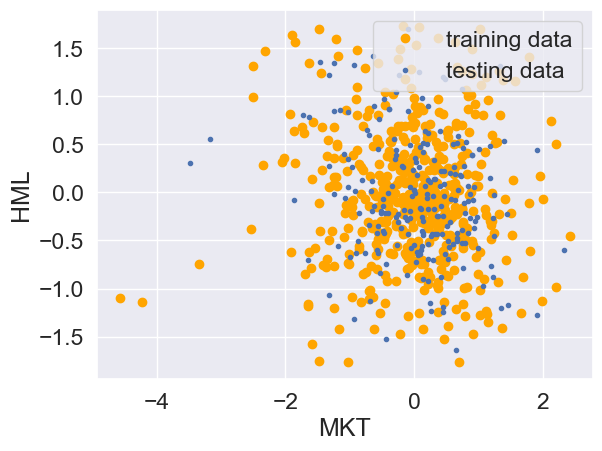

/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


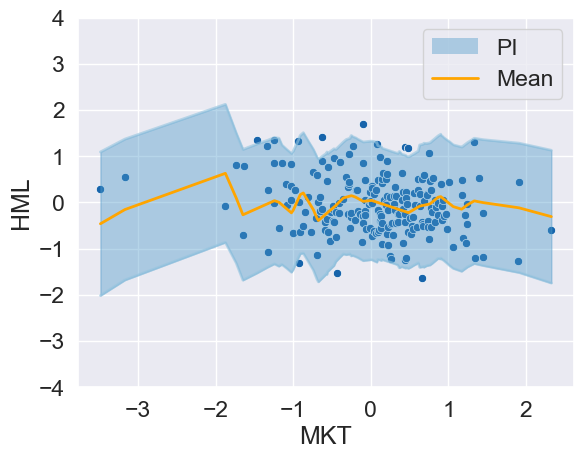

The overall coverage is 0.958904109589041
The mean bandwidth for testing data is 1.6467572600249694
The median bandwidth for testing data is 1.6478525103055068


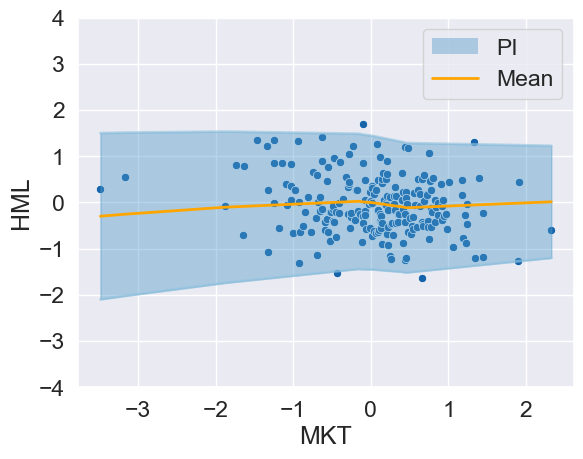

The overall coverage is 0.9771689497716894
The mean bandwidth for testing data is 2.087720210323887
The median bandwidth for testing data is 2.058872114995579


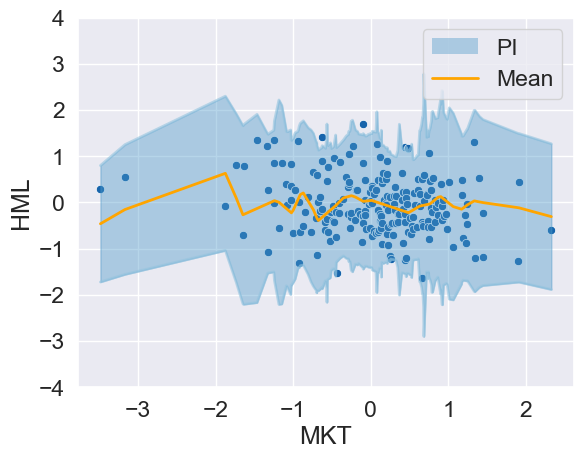

The overall coverage is 0.9726027397260274
The mean bandwidth for testing data is 2.363595486922711
The median bandwidth for testing data is 2.132922757660684


In [13]:
################################ MKT VS HML #####################################

##################### Making (X, Y) ###########################

X_axis = "MKT"
Y_axis = "HML"
X = MKT_te
Y = HML_te

# cut = np.where((X<=1.5) & (X>=-1.5))[0]
# X = X[cut,:]
# Y = Y[cut,:]
#print("By constraint on [-1.5,1.5], the number of data being removed is ", MKT_te.shape[0]-X.shape[0])

# Remove outliers (w.r.t Y ) using IQR
Data = np.hstack([X,Y])
Q1 = np.percentile(Y, 25, method = 'midpoint')
Q3 = np.percentile(Y, 75, method = 'midpoint')
IQR = Q3 - Q1
upper=Q3+1.5*IQR
upper_array=np.array(Y<=upper)
lower=Q1-1.5*IQR
lower_array=np.array(Y>=lower)
index_keep = upper_array & lower_array
Data = Data[index_keep[:,0].tolist(),:]
print("By removing outliers w.r.t y, the number of data being removed is ", Y.shape[0]-Data.shape[0])

np.random.seed(10)
np.random.shuffle(Data)
train_idx = int(Data.shape[0] * 0.8)
train_data, test_data = np.split(Data, [train_idx])

########################### UTOPIA #########################

X_pre = train_data[:500,0].reshape(-1,1)
Y_pre = train_data[:500,1].reshape(-1,1)

X_opt = train_data[500:700,0].reshape(-1,1)
Y_opt = train_data[500:700,1].reshape(-1,1)

X_adj = train_data[700:,0].reshape(-1,1)
Y_adj = train_data[700:,1].reshape(-1,1)


X_t = test_data[:,0].reshape(-1,1)
Y_t = test_data[:,1].reshape(-1,1)



n_pre = len(X_pre)
n_opt = len(X_opt)
n_adj = len(X_adj)
n_t = len(X_t)

# plot training and testing data
plt.plot(X_pre,Y_pre,'o',color = 'orange',label = 'training data')
plt.plot(X_t,Y_t,'.', label = 'testing data')
plt.xlabel(X_axis)
plt.ylabel(Y_axis)
plt.legend(loc="upper right")
plt.show()


#est_type = "NN2"
M_pre, M_opt, M_adj, M_t = mean_est("NN2", X_pre,Y_pre,X_opt,X_adj,X_t)
var_opt, var_adj, var_t = var_est(X_pre,Y_pre,M_pre, X_opt,X_adj,X_t, 5, "RF")

quantile = [0.05,0.35,0.65,0.95]
m1,Q1_opt,Q1_adj,Q1_t = est_quantile("NN1",quantile[0],X_pre,Y_pre,X_opt,X_adj,X_t)
m2,Q2_opt,Q2_adj,Q2_t = est_quantile("NN2",quantile[1],X_pre,Y_pre,X_opt,X_adj,X_t)
m3,Q3_opt,Q3_adj,Q3_t = est_quantile("qrf",quantile[2],X_pre,Y_pre,X_opt,X_adj,X_t)
m4,Q4_opt,Q4_adj,Q4_t = est_quantile("gb",quantile[3],X_pre,Y_pre,X_opt,X_adj,X_t)

# construct estimator matrix
E_opt = np.hstack(((Q1_opt-M_opt)**2, (Q2_opt-M_opt)**2, (Q3_opt-M_opt)**2, (Q4_opt-M_opt)**2, var_opt.reshape(-1, 1)))
E_opt = E_opt.T
E_adj = np.hstack(((Q1_adj-M_adj)**2, (Q2_adj-M_adj)**2, (Q3_adj-M_adj)**2, (Q4_adj-M_adj)**2, var_adj.reshape(-1, 1)))
E_adj = E_adj.T
E_t = np.hstack(((Q1_t-M_t)**2, (Q2_t-M_t)**2, (Q3_t-M_t)**2, (Q4_t-M_t)**2, var_t.reshape(-1, 1)))
E_t = E_t.T

optimal_weight, V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "aug", E_opt, E_adj, E_t)

alpha = 0.05
delta = interval_adj_2(X_adj,Y_adj,M_adj,V100_adj,alpha)

V_alpha_t = delta*V100_t
my_plot(X_t,Y_t,M_t,V_alpha_t,X_axis = X_axis, Y_axis = Y_axis,ylim = [-4,4])



########################### LQR #########################

# lin_idx = int(Data.shape[0] * 0.4)
# quantile_idx = int(Data.shape[0] * 0.8)
# lin_data, quantile_data, test_data = np.split(Data, [lin_idx, quantile_idx])

# X_lin = lin_data[:,0].reshape(-1,1)
# Y_lin = lin_data[:,1].reshape(-1,1)
# y_lin = Y_lin[:,0]
# X_quantile = quantile_data[:,0].reshape(-1,1)
# Y_quantile = quantile_data[:,1].reshape(-1,1)
# X_test = test_data[:,0].reshape(-1,1)
# Y_test = test_data[:,1].reshape(-1,1)


X_lin = train_data[:,0].reshape(-1,1)
Y_lin = train_data[:,1].reshape(-1,1)
y_lin = Y_lin[:,0]
X_quantile = train_data[:,0].reshape(-1,1)
Y_quantile = train_data[:,1].reshape(-1,1)
X_test = test_data[:,0].reshape(-1,1)
Y_test = test_data[:,1].reshape(-1,1)

# Estimate the mean using NN1
est_type = "NN1"
M_quantile, M_test = mean_est_2(est_type,X_lin,Y_lin,X_quantile,X_test)

# Estimate the quantile
alpha = 0.05

model_quantile = QuantileRegressor(quantile=1-(alpha/2), alpha=0,solver='highs')
model_quantile.fit(X_quantile, (Y_quantile-M_quantile).reshape(-1))
Q_test = model_quantile.predict(X_test)


V_test = Q_test**2
V_test = V_test.reshape(-1,1)

my_plot(X_test,Y_test,M_test,V_test,X_axis = X_axis, Y_axis = Y_axis,ylim=[-4,4])




######################## Variance adjusted Split CF #################

X_mean = train_data[:500,0].reshape(-1,1)
Y_mean = train_data[:500,1].reshape(-1,1)

X_res = train_data[500:,0].reshape(-1,1)
Y_res = train_data[500:,1].reshape(-1,1)

X_test = test_data[:,0].reshape(-1,1)
Y_test = test_data[:,1].reshape(-1,1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
torch.cuda.manual_seed_all(42) 
input_dim = X_mean.shape[1]
model = NN2(input_size=input_dim, output_size=1).to(device)
criterion=nn.MSELoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(1000):
    inputs=Variable(torch.from_numpy(X_mean))
    labels=Variable(torch.from_numpy(Y_mean))
    optimizer.zero_grad()
    outputs=model(inputs.float())
    loss=criterion(outputs.float(), labels.float())
    loss.backward()
    optimizer.step()

    
Y_mean_hat = model(torch.from_numpy(X_mean).float())
Y_mean_hat = Y_mean_hat.detach().cpu().numpy().reshape(-1,1)

Y_res_hat = model(torch.from_numpy(X_res).float())
Y_res_hat = Y_res_hat.detach().cpu().numpy().reshape(-1,1)

Y_test_hat = model(torch.from_numpy(X_test).float())
Y_test_hat = Y_test_hat.detach().cpu().numpy().reshape(-1,1)


resid_mean = Y_mean[:,0] - Y_mean_hat[:,0]


########################### RF based conditional variance estimator ##########################

var_model = RandomForestRegressor(n_estimators = 1000, max_depth = 5, random_state = 42)
#var_model = RandomForestRegressor(n_estimators = 1000, max_depth = 3)
var_model.fit(X_mean, resid_mean ** 2)

var_mean_hat = var_model.predict(X_mean)
var_res_hat = var_model.predict(X_res)
var_test_hat = var_model.predict(X_test)

alpha = 0.05
residuals = np.abs(Y_res[:,0] - Y_res_hat[:,0])/((var_res_hat ** 0.5) + 1e-10)
k = int((1 - alpha) * len(residuals))
residuals_sorted = np.sort(residuals)
threshold = residuals_sorted[k]

v_test = (threshold**2)*var_test_hat
V_test = v_test.reshape(-1,1)


# ########################### NN1 based conditional variance estimator ##########################

# input_dim = X_mean.shape[0]
# X = X_mean.reshape(-1,)
# Y = resid_mean ** 2
# Y = Y.reshape(-1,)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch.manual_seed(42)
# torch.cuda.manual_seed_all(42) 
# model = NN1(input_size=input_dim, output_size=1).to(device)
# criterion=nn.MSELoss()
# learning_rate = 0.001
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# for epoch in range(1000):
#     #convert numpy array to torch Variable
#     inputs=Variable(torch.from_numpy(X))
#     labels=Variable(torch.from_numpy(Y))

#     #clear gradients wrt parameters
#     optimizer.zero_grad()

#     #Forward to get outputs
#     outputs=model(inputs.float())

#     #calculate loss
#     loss=criterion(outputs.float(), labels.float())

#     #getting gradients wrt parameters
#     loss.backward()

#     #updating parameters
#     optimizer.step()

    
# var_res_hat = model(torch.from_numpy(X_res).float()).detach().cpu().numpy().reshape(-1,1)
# var_test_hat = model(torch.from_numpy(X_test).float()).detach().cpu().numpy().reshape(-1,1)

alpha = 0.05
residuals = np.abs(Y_res[:,0] - Y_res_hat[:,0])/((var_res_hat ** 0.5) + 1e-10)
k = int((1 - alpha) * len(residuals))
residuals_sorted = np.sort(residuals)
threshold = residuals_sorted[k]

v_test = (threshold**2)*var_test_hat
V_test = v_test.reshape(-1,1)


# plot 
my_plot(X_test,Y_test,Y_test_hat,V_test,X_axis = X_axis, Y_axis = Y_axis,ylim = [-4,4])

By removing outliers w.r.t y, the number of data being removed is  34


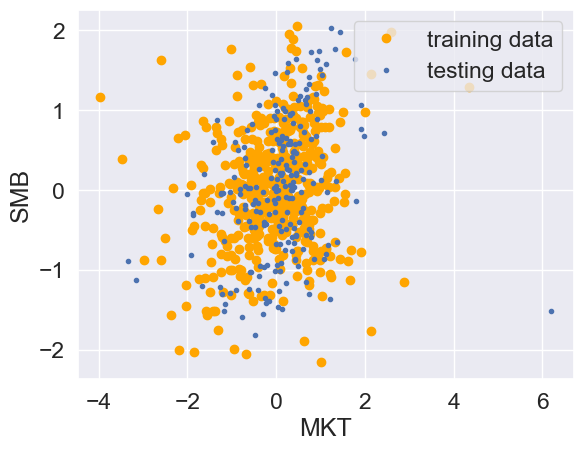

/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


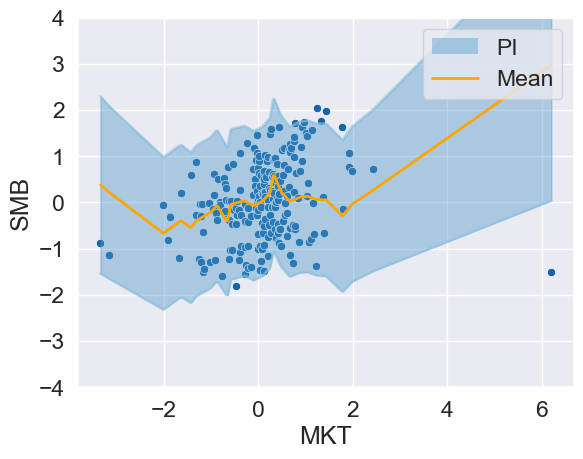

The overall coverage is 0.9690265486725663
The mean bandwidth for testing data is 2.686708111641126
The median bandwidth for testing data is 2.642880809294449


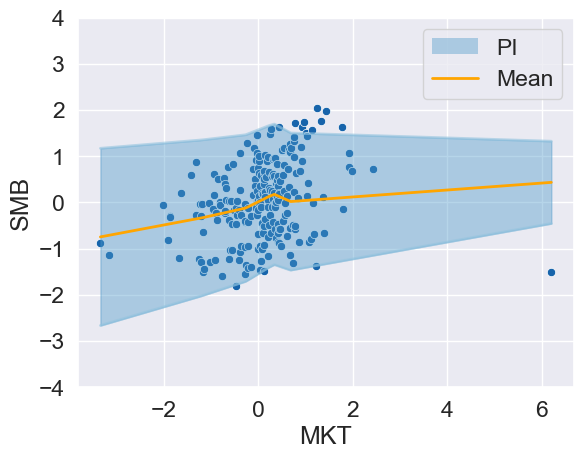

The overall coverage is 0.9380530973451328
The mean bandwidth for testing data is 2.409352351908076
The median bandwidth for testing data is 2.383880075635826


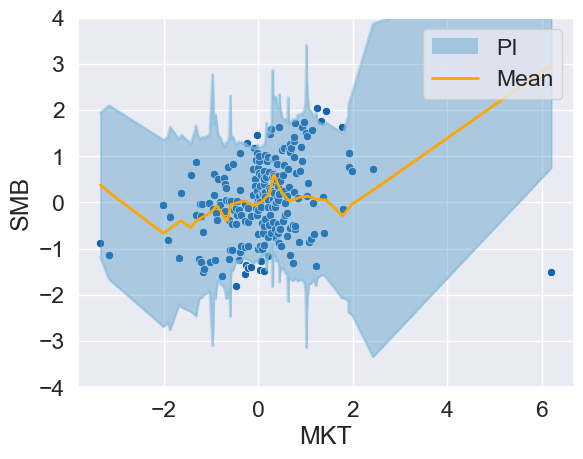

The overall coverage is 0.9247787610619469
The mean bandwidth for testing data is 2.6438657823923233
The median bandwidth for testing data is 2.684185295779898


In [14]:
################################ MKT VS SMB #####################################

##################### Making (X, Y) ###########################

X_axis = "MKT"
Y_axis = "SMB"
X = MKT_te
Y = SMB_te


Data = np.hstack([X,Y])
Q1 = np.percentile(Y, 25, method = 'midpoint')
Q3 = np.percentile(Y, 75, method = 'midpoint')
IQR = Q3 - Q1
upper=Q3+1.5*IQR
upper_array=np.array(Y<=upper)
lower=Q1-1.5*IQR
lower_array=np.array(Y>=lower)
index_keep = upper_array & lower_array
Data = Data[index_keep[:,0].tolist(),:]
print("By removing outliers w.r.t y, the number of data being removed is ", Y.shape[0]-Data.shape[0])

np.random.seed(10)
np.random.shuffle(Data)
train_idx = int(Data.shape[0] * 0.8)
train_data, test_data = np.split(Data, [train_idx])


# cut = np.where((X<=1.5) & (X>=-1.5))[0]
# X = X[cut,:]
# Y = Y[cut,:]
#print("By constraint on [-1.5,1.5], the number of data being removed is ", MKT_te.shape[0]-X.shape[0])

# Remove outliers (w.r.t Y ) using IQR
########################### UTOPIA #########################

X_pre = train_data[:500,0].reshape(-1,1)
Y_pre = train_data[:500,1].reshape(-1,1)

X_opt = train_data[500:700,0].reshape(-1,1)
Y_opt = train_data[500:700,1].reshape(-1,1)

X_adj = train_data[700:,0].reshape(-1,1)
Y_adj = train_data[700:,1].reshape(-1,1)


X_t = test_data[:,0].reshape(-1,1)
Y_t = test_data[:,1].reshape(-1,1)



n_pre = len(X_pre)
n_opt = len(X_opt)
n_adj = len(X_adj)
n_t = len(X_t)

# plot training and testing data
plt.plot(X_pre,Y_pre,'o',color = 'orange',label = 'training data')
plt.plot(X_t,Y_t,'.', label = 'testing data')
plt.xlabel(X_axis)
plt.ylabel(Y_axis)
plt.legend(loc="upper right")
plt.show()


#est_type = "NN2"
M_pre, M_opt, M_adj, M_t = mean_est("NN2", X_pre,Y_pre,X_opt,X_adj,X_t)
var_opt, var_adj, var_t = var_est(X_pre,Y_pre,M_pre, X_opt,X_adj,X_t, 5, "RF")

quantile = [0.05,0.35,0.65,0.95]
m1,Q1_opt,Q1_adj,Q1_t = est_quantile("NN1",quantile[0],X_pre,Y_pre,X_opt,X_adj,X_t)
m2,Q2_opt,Q2_adj,Q2_t = est_quantile("NN2",quantile[1],X_pre,Y_pre,X_opt,X_adj,X_t)
m3,Q3_opt,Q3_adj,Q3_t = est_quantile("qrf",quantile[2],X_pre,Y_pre,X_opt,X_adj,X_t)
m4,Q4_opt,Q4_adj,Q4_t = est_quantile("gb",quantile[3],X_pre,Y_pre,X_opt,X_adj,X_t)

# construct estimator matrix
E_opt = np.hstack(((Q1_opt-M_opt)**2, (Q2_opt-M_opt)**2, (Q3_opt-M_opt)**2, (Q4_opt-M_opt)**2, var_opt.reshape(-1, 1)))
E_opt = E_opt.T
E_adj = np.hstack(((Q1_adj-M_adj)**2, (Q2_adj-M_adj)**2, (Q3_adj-M_adj)**2, (Q4_adj-M_adj)**2, var_adj.reshape(-1, 1)))
E_adj = E_adj.T
E_t = np.hstack(((Q1_t-M_t)**2, (Q2_t-M_t)**2, (Q3_t-M_t)**2, (Q4_t-M_t)**2, var_t.reshape(-1, 1)))
E_t = E_t.T

optimal_weight, V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "aug", E_opt, E_adj, E_t)

alpha = 0.05
delta = interval_adj(X_adj,Y_adj,M_adj,V100_adj,alpha)

V_alpha_t = delta*V100_t
my_plot(X_t,Y_t,M_t,V_alpha_t,X_axis = X_axis, Y_axis = Y_axis,ylim = [-4,4])



########################### LQR #########################

# lin_idx = int(Data.shape[0] * 0.4)
# quantile_idx = int(Data.shape[0] * 0.8)
# lin_data, quantile_data, test_data = np.split(Data, [lin_idx, quantile_idx])

# X_lin = lin_data[:,0].reshape(-1,1)
# Y_lin = lin_data[:,1].reshape(-1,1)
# y_lin = Y_lin[:,0]
# X_quantile = quantile_data[:,0].reshape(-1,1)
# Y_quantile = quantile_data[:,1].reshape(-1,1)
# X_test = test_data[:,0].reshape(-1,1)
# Y_test = test_data[:,1].reshape(-1,1)


X_lin = train_data[:,0].reshape(-1,1)
Y_lin = train_data[:,1].reshape(-1,1)
y_lin = Y_lin[:,0]
X_quantile = train_data[:,0].reshape(-1,1)
Y_quantile = train_data[:,1].reshape(-1,1)
X_test = test_data[:,0].reshape(-1,1)
Y_test = test_data[:,1].reshape(-1,1)

# Estimate the mean using NN1
est_type = "NN1"
M_quantile, M_test = mean_est_2(est_type,X_lin,Y_lin,X_quantile,X_test)

# Estimate the quantile
alpha = 0.05

model_quantile = QuantileRegressor(quantile=1-(alpha/2), alpha=0,solver='highs')
model_quantile.fit(X_quantile, (Y_quantile-M_quantile).reshape(-1))
Q_test = model_quantile.predict(X_test)


V_test = Q_test**2
V_test = V_test.reshape(-1,1)

my_plot(X_test,Y_test,M_test,V_test,X_axis = X_axis, Y_axis = Y_axis,ylim=[-4,4])




######################## Variance adjusted Split CF #################

X_mean = train_data[:500,0].reshape(-1,1)
Y_mean = train_data[:500,1].reshape(-1,1)

X_res = train_data[500:,0].reshape(-1,1)
Y_res = train_data[500:,1].reshape(-1,1)

X_test = test_data[:,0].reshape(-1,1)
Y_test = test_data[:,1].reshape(-1,1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
torch.cuda.manual_seed_all(42) 
input_dim = X_mean.shape[1]
model = NN2(input_size=input_dim, output_size=1).to(device)
criterion=nn.MSELoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(1000):
    inputs=Variable(torch.from_numpy(X_mean))
    labels=Variable(torch.from_numpy(Y_mean))
    optimizer.zero_grad()
    outputs=model(inputs.float())
    loss=criterion(outputs.float(), labels.float())
    loss.backward()
    optimizer.step()

    
Y_mean_hat = model(torch.from_numpy(X_mean).float())
Y_mean_hat = Y_mean_hat.detach().cpu().numpy().reshape(-1,1)

Y_res_hat = model(torch.from_numpy(X_res).float())
Y_res_hat = Y_res_hat.detach().cpu().numpy().reshape(-1,1)

Y_test_hat = model(torch.from_numpy(X_test).float())
Y_test_hat = Y_test_hat.detach().cpu().numpy().reshape(-1,1)


resid_mean = Y_mean[:,0] - Y_mean_hat[:,0]


########################### RF based conditional variance estimator ##########################

var_model = RandomForestRegressor(n_estimators = 1000, max_depth = 5, random_state = 42)
#var_model = RandomForestRegressor(n_estimators = 1000, max_depth = 3)
var_model.fit(X_mean, resid_mean ** 2)

var_mean_hat = var_model.predict(X_mean)
var_res_hat = var_model.predict(X_res)
var_test_hat = var_model.predict(X_test)

alpha = 0.05
residuals = np.abs(Y_res[:,0] - Y_res_hat[:,0])/((var_res_hat ** 0.5) + 1e-10)
k = int((1 - alpha) * len(residuals))
residuals_sorted = np.sort(residuals)
threshold = residuals_sorted[k]

v_test = (threshold**2)*var_test_hat
V_test = v_test.reshape(-1,1)


# ########################### NN1 based conditional variance estimator ##########################

# input_dim = X_mean.shape[0]
# X = X_mean.reshape(-1,)
# Y = resid_mean ** 2
# Y = Y.reshape(-1,)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch.manual_seed(42)
# torch.cuda.manual_seed_all(42) 
# model = NN1(input_size=input_dim, output_size=1).to(device)
# criterion=nn.MSELoss()
# learning_rate = 0.001
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# for epoch in range(1000):
#     #convert numpy array to torch Variable
#     inputs=Variable(torch.from_numpy(X))
#     labels=Variable(torch.from_numpy(Y))

#     #clear gradients wrt parameters
#     optimizer.zero_grad()

#     #Forward to get outputs
#     outputs=model(inputs.float())

#     #calculate loss
#     loss=criterion(outputs.float(), labels.float())

#     #getting gradients wrt parameters
#     loss.backward()

#     #updating parameters
#     optimizer.step()

    
# var_res_hat = model(torch.from_numpy(X_res).float()).detach().cpu().numpy().reshape(-1,1)
# var_test_hat = model(torch.from_numpy(X_test).float()).detach().cpu().numpy().reshape(-1,1)

alpha = 0.05
residuals = np.abs(Y_res[:,0] - Y_res_hat[:,0])/((var_res_hat ** 0.5) + 1e-10)
k = int((1 - alpha) * len(residuals))
residuals_sorted = np.sort(residuals)
threshold = residuals_sorted[k]

v_test = (threshold**2)*var_test_hat
V_test = v_test.reshape(-1,1)


# plot 
my_plot(X_test,Y_test,Y_test_hat,V_test,X_axis = X_axis, Y_axis = Y_axis,ylim = [-4,4])

By removing outliers w.r.t y, the number of data being removed is  17


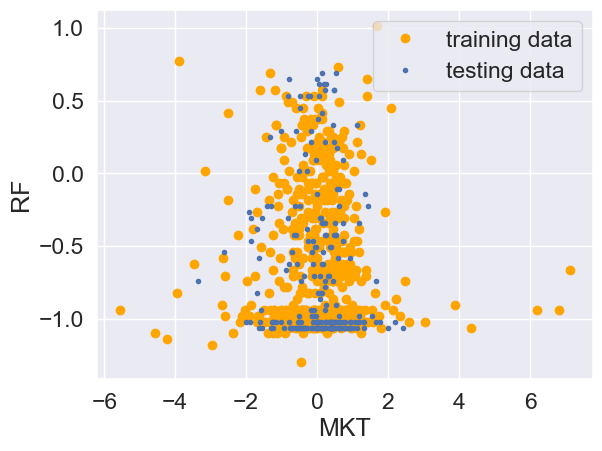

/Users/mdeb/BOSTON UNIVERSITY Dropbox/Debarghya Mukherjee/Jiawei/Prediction Band/Codes/All_functions_simulation_univariate.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  var_model.fit(X, Y.reshape(-1,1))


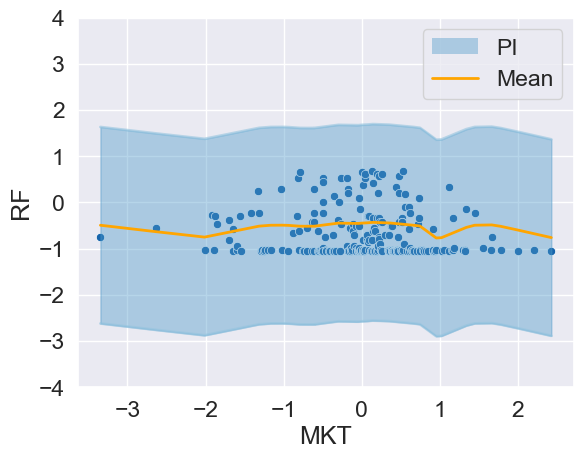

The overall coverage is 1.0
The mean bandwidth for testing data is 4.521407766618893
The median bandwidth for testing data is 4.521407766925361


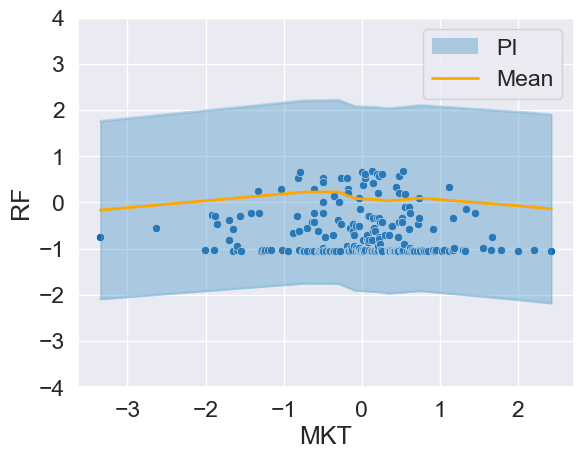

The overall coverage is 1.0
The mean bandwidth for testing data is 3.964451437105126
The median bandwidth for testing data is 3.971152903802773


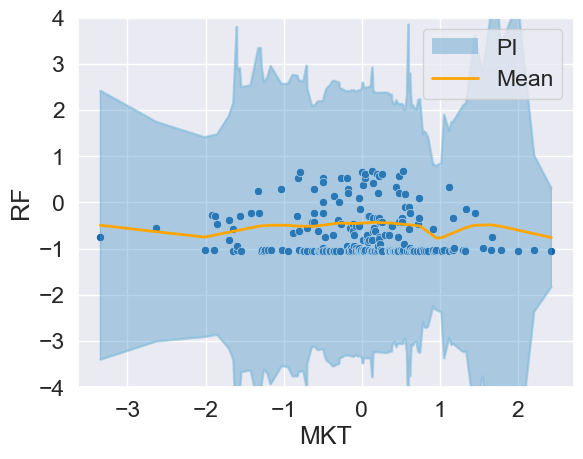

The overall coverage is 1.0
The mean bandwidth for testing data is 8.255317085970722
The median bandwidth for testing data is 7.887186260207591


In [8]:
################################ MKT VS RF #####################################

##################### Making (X, Y) ###########################

X_axis = "MKT"
Y_axis = "RF"
X = MKT_te
Y = RF_te


Data = np.hstack([X,Y])
Q1 = np.percentile(Y, 25, method = 'midpoint')
Q3 = np.percentile(Y, 75, method = 'midpoint')
IQR = Q3 - Q1
upper=Q3+1.5*IQR
upper_array=np.array(Y<=upper)
lower=Q1-1.5*IQR
lower_array=np.array(Y>=lower)
index_keep = upper_array & lower_array
Data = Data[index_keep[:,0].tolist(),:]
print("By removing outliers w.r.t y, the number of data being removed is ", Y.shape[0]-Data.shape[0])

# np.random.seed(2)
# np.random.shuffle(Data)
train_idx = int(Data.shape[0] * 0.8)
train_data, test_data = np.split(Data, [train_idx])

# cut = np.where((X<=1.5) & (X>=-1.5))[0]
# X = X[cut,:]
# Y = Y[cut,:]
#print("By constraint on [-1.5,1.5], the number of data being removed is ", MKT_te.shape[0]-X.shape[0])

# Remove outliers (w.r.t Y ) using IQR
########################### UTOPIA #########################

X_pre = train_data[:500,0].reshape(-1,1)
Y_pre = train_data[:500,1].reshape(-1,1)

X_opt = train_data[500:700,0].reshape(-1,1)
Y_opt = train_data[500:700,1].reshape(-1,1)

X_adj = train_data[700:,0].reshape(-1,1)
Y_adj = train_data[700:,1].reshape(-1,1)


X_t = test_data[:,0].reshape(-1,1)
Y_t = test_data[:,1].reshape(-1,1)



n_pre = len(X_pre)
n_opt = len(X_opt)
n_adj = len(X_adj)
n_t = len(X_t)

# plot training and testing data
plt.plot(X_pre,Y_pre,'o',color = 'orange',label = 'training data')
plt.plot(X_t,Y_t,'.', label = 'testing data')
plt.xlabel(X_axis)
plt.ylabel(Y_axis)
plt.legend(loc="upper right")
plt.show()


#est_type = "NN2"
M_pre, M_opt, M_adj, M_t = mean_est("NN2", X_pre,Y_pre,X_opt,X_adj,X_t)
var_opt, var_adj, var_t = var_est(X_pre,Y_pre,M_pre, X_opt,X_adj,X_t, 5, "RF")

quantile = [0.05,0.35,0.65,0.95]
m1,Q1_opt,Q1_adj,Q1_t = est_quantile("NN1",quantile[0],X_pre,Y_pre,X_opt,X_adj,X_t)
m2,Q2_opt,Q2_adj,Q2_t = est_quantile("NN2",quantile[1],X_pre,Y_pre,X_opt,X_adj,X_t)
m3,Q3_opt,Q3_adj,Q3_t = est_quantile("qrf",quantile[2],X_pre,Y_pre,X_opt,X_adj,X_t)
m4,Q4_opt,Q4_adj,Q4_t = est_quantile("gb",quantile[3],X_pre,Y_pre,X_opt,X_adj,X_t)

# construct estimator matrix
E_opt = np.hstack(((Q1_opt-M_opt)**2, (Q2_opt-M_opt)**2, (Q3_opt-M_opt)**2, (Q4_opt-M_opt)**2, var_opt.reshape(-1, 1)))
E_opt = E_opt.T
E_adj = np.hstack(((Q1_adj-M_adj)**2, (Q2_adj-M_adj)**2, (Q3_adj-M_adj)**2, (Q4_adj-M_adj)**2, var_adj.reshape(-1, 1)))
E_adj = E_adj.T
E_t = np.hstack(((Q1_t-M_t)**2, (Q2_t-M_t)**2, (Q3_t-M_t)**2, (Q4_t-M_t)**2, var_t.reshape(-1, 1)))
E_t = E_t.T

optimal_weight, V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "aug", E_opt, E_adj, E_t)

alpha = 0.05
delta = interval_adj(X_adj,Y_adj,M_adj,V100_adj,alpha)

V_alpha_t = delta*V100_t
my_plot(X_t,Y_t,M_t,V_alpha_t,X_axis = X_axis, Y_axis = Y_axis,ylim = [-4,4])



########################### LQR #########################

# lin_idx = int(Data.shape[0] * 0.4)
# quantile_idx = int(Data.shape[0] * 0.8)
# lin_data, quantile_data, test_data = np.split(Data, [lin_idx, quantile_idx])

# X_lin = lin_data[:,0].reshape(-1,1)
# Y_lin = lin_data[:,1].reshape(-1,1)
# y_lin = Y_lin[:,0]
# X_quantile = quantile_data[:,0].reshape(-1,1)
# Y_quantile = quantile_data[:,1].reshape(-1,1)
# X_test = test_data[:,0].reshape(-1,1)
# Y_test = test_data[:,1].reshape(-1,1)


X_lin = train_data[:,0].reshape(-1,1)
Y_lin = train_data[:,1].reshape(-1,1)
y_lin = Y_lin[:,0]
X_quantile = train_data[:,0].reshape(-1,1)
Y_quantile = train_data[:,1].reshape(-1,1)
X_test = test_data[:,0].reshape(-1,1)
Y_test = test_data[:,1].reshape(-1,1)

# Estimate the mean using NN1
est_type = "NN1"
M_quantile, M_test = mean_est_2(est_type,X_lin,Y_lin,X_quantile,X_test)

# Estimate the quantile
alpha = 0.05

model_quantile = QuantileRegressor(quantile=1-(alpha/2), alpha=0,solver='highs')
model_quantile.fit(X_quantile, (Y_quantile-M_quantile).reshape(-1))
Q_test = model_quantile.predict(X_test)


V_test = Q_test**2
V_test = V_test.reshape(-1,1)

my_plot(X_test,Y_test,M_test,V_test,X_axis = X_axis, Y_axis = Y_axis,ylim=[-4,4])




######################## Variance adjusted Split CF #################

X_mean = train_data[:500,0].reshape(-1,1)
Y_mean = train_data[:500,1].reshape(-1,1)

X_res = train_data[500:,0].reshape(-1,1)
Y_res = train_data[500:,1].reshape(-1,1)

X_test = test_data[:,0].reshape(-1,1)
Y_test = test_data[:,1].reshape(-1,1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
torch.cuda.manual_seed_all(42) 
input_dim = X_mean.shape[1]
model = NN2(input_size=input_dim, output_size=1).to(device)
criterion=nn.MSELoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(1000):
    inputs=Variable(torch.from_numpy(X_mean))
    labels=Variable(torch.from_numpy(Y_mean))
    optimizer.zero_grad()
    outputs=model(inputs.float())
    loss=criterion(outputs.float(), labels.float())
    loss.backward()
    optimizer.step()

    
Y_mean_hat = model(torch.from_numpy(X_mean).float())
Y_mean_hat = Y_mean_hat.detach().cpu().numpy().reshape(-1,1)

Y_res_hat = model(torch.from_numpy(X_res).float())
Y_res_hat = Y_res_hat.detach().cpu().numpy().reshape(-1,1)

Y_test_hat = model(torch.from_numpy(X_test).float())
Y_test_hat = Y_test_hat.detach().cpu().numpy().reshape(-1,1)


resid_mean = Y_mean[:,0] - Y_mean_hat[:,0]


########################### RF based conditional variance estimator ##########################

var_model = RandomForestRegressor(n_estimators = 1000, max_depth = 5, random_state = 42)
#var_model = RandomForestRegressor(n_estimators = 1000, max_depth = 3)
var_model.fit(X_mean, resid_mean ** 2)

var_mean_hat = var_model.predict(X_mean)
var_res_hat = var_model.predict(X_res)
var_test_hat = var_model.predict(X_test)

alpha = 0.05
residuals = np.abs(Y_res[:,0] - Y_res_hat[:,0])/((var_res_hat ** 0.5) + 1e-10)
k = int((1 - alpha) * len(residuals))
residuals_sorted = np.sort(residuals)
threshold = residuals_sorted[k]

v_test = (threshold**2)*var_test_hat
V_test = v_test.reshape(-1,1)


# ########################### NN1 based conditional variance estimator ##########################

# input_dim = X_mean.shape[0]
# X = X_mean.reshape(-1,)
# Y = resid_mean ** 2
# Y = Y.reshape(-1,)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch.manual_seed(42)
# torch.cuda.manual_seed_all(42) 
# model = NN1(input_size=input_dim, output_size=1).to(device)
# criterion=nn.MSELoss()
# learning_rate = 0.001
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# for epoch in range(1000):
#     #convert numpy array to torch Variable
#     inputs=Variable(torch.from_numpy(X))
#     labels=Variable(torch.from_numpy(Y))

#     #clear gradients wrt parameters
#     optimizer.zero_grad()

#     #Forward to get outputs
#     outputs=model(inputs.float())

#     #calculate loss
#     loss=criterion(outputs.float(), labels.float())

#     #getting gradients wrt parameters
#     loss.backward()

#     #updating parameters
#     optimizer.step()

    
# var_res_hat = model(torch.from_numpy(X_res).float()).detach().cpu().numpy().reshape(-1,1)
# var_test_hat = model(torch.from_numpy(X_test).float()).detach().cpu().numpy().reshape(-1,1)

alpha = 0.05
residuals = np.abs(Y_res[:,0] - Y_res_hat[:,0])/((var_res_hat ** 0.5) + 1e-10)
k = int((1 - alpha) * len(residuals))
residuals_sorted = np.sort(residuals)
threshold = residuals_sorted[k]

v_test = (threshold**2)*var_test_hat
V_test = v_test.reshape(-1,1)


# plot 
my_plot(X_test,Y_test,Y_test_hat,V_test,X_axis = X_axis, Y_axis = Y_axis,ylim = [-4,4])